#CODE

### Install Pyspark & Time-Storage

Installing Pyspark package

In [79]:
!pip install pyspark

Time and Source

In [80]:
import time
import psutil

### Reading Data

Read the data and display all the columns to have a look at it.

In [81]:
from pyspark.sql import SparkSession
start_time = time.time()
total_time = time.time()
total_CPU = psutil.cpu_percent()
total_RAM = psutil.virtual_memory().percent

spark = SparkSession.builder.appName("Hotels").getOrCreate()

path = "/content/hotel_bookings.csv"
df = spark.read.csv(path, header=True, inferSchema=True)
df.show(3)

end_time = time.time()
print("Time: " , end_time - start_time)
print("CPU: " , psutil.cpu_percent())
print("RAM: " , psutil.virtual_memory().percent)

+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+----+---------------------------+-------------------------+------------------+-----------------------+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type| adr|required_car_parking_spaces|total_

### Preparing Data & General Statistics

In [82]:
start_time = time.time()

Check data size

In [83]:
rows = df.count()
columns = len(df.columns)
shape = (rows, columns)
print(shape)

(119390, 32)


Check unique values of each features to see what features that may has 1 unique value (which means all the instances share the same value) or that has same number of unique values as the row size (119390) which will not be useful for EDA nor Modelling.

In [84]:
from pyspark.sql import functions as F
unique_counts = {}
for column in df.columns:
    unique_counts[column] = df.select(column).distinct().count()
print(unique_counts)

{'hotel': 2, 'is_canceled': 2, 'lead_time': 479, 'arrival_date_year': 3, 'arrival_date_month': 12, 'arrival_date_week_number': 53, 'arrival_date_day_of_month': 31, 'stays_in_weekend_nights': 17, 'stays_in_week_nights': 35, 'adults': 14, 'children': 6, 'babies': 5, 'meal': 5, 'country': 178, 'market_segment': 8, 'distribution_channel': 5, 'is_repeated_guest': 2, 'previous_cancellations': 15, 'previous_bookings_not_canceled': 73, 'reserved_room_type': 10, 'assigned_room_type': 12, 'booking_changes': 21, 'deposit_type': 3, 'agent': 334, 'company': 353, 'days_in_waiting_list': 128, 'customer_type': 4, 'adr': 8879, 'required_car_parking_spaces': 5, 'total_of_special_requests': 6, 'reservation_status': 3, 'reservation_status_date': 926}


Check Duplication instances and delete them



*   Duplication instances may caused because of several room bookings occured by an agent for the same event
*   Deleting them will help insights be more realistic without creating biases
*   Deleting them will reflect the truth especially for cancellation status. Instead of saying "multiple reservations cancelled by that agent" it will say "The agent cancelled his reservation for that event"



In [85]:
duplication = df.count() - df.dropDuplicates().count()
print(duplication)

df = df.toPandas()
df = df.drop_duplicates(keep = False)
print(df.shape)

31994
(79225, 32)


Check Null values for each column which shows that:
* Children has 4 null values
* country has 442 null values
* agent has 11120
* company has 74483

In [86]:
import numpy as np
df = df.replace('NULL' , np.nan)
df = df.replace('NA' , np.nan)
df.isnull().sum()

,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


Removing couple of features that will not help:
* Reservation_status Date: Express the date of that event. Already have features that express the year, month and the day of the reservation.
* Company: Express the event country take place. almost 95% of the values of this feautre are Null.
* Arrival_date_week_number: Express the week number according to the year's weeks. Not needed since we have the detailed date of that event.
* Is_Canceled: Express whether the reservation is cancelled or occured peacefully. We have a similar feature that shows whether the reservation got cancelled or checked in sucessfully called reservation_status.

In [87]:
df = spark.createDataFrame(df)
df = df.drop('reservation_status_date', 'company', 'arrival_date_week_number', 'is_canceled', 'adr')

Instead of having two features, one for the nights spent in weekend days and one for the nights spent in weekdays. We made aggregation function to make them a single feature that contains the total nights spent during the reservation. And then removed that two features. In that case, more useful information by applying dimentions reduction

In [88]:
from pyspark.sql.functions import col

df = df.withColumn("number_of_nights", col("stays_in_weekend_nights") + col("stays_in_week_nights"))
df = df.drop("stays_in_weekend_nights", "stays_in_week_nights")

We created a dataframe that contains only the instances that has the reservation_status = Check-Out. Then a condition to see the instances that has number of nights equals to 0. We considered the reservation statue means reserving the hotel room, which even if the reservation did not complete 12 hours, it will be counted as 1. So, we increased 1 for all instances that has Check-Out value in the reservation status only.

In [89]:
from pyspark.sql.functions import when

checker = df.filter(col('reservation_status') == 'Check-Out')
true_count = checker.filter(col('number_of_nights') == 0).count()
false_count = checker.count() - true_count

print(f"\nCheck-Out With No Nights: {true_count}")
print(f"Check-Out With Nights: {false_count}")

df = df.withColumn(
    'number_of_nights',
    when(col('reservation_status') == 'Check-Out', col('number_of_nights') + 1).otherwise(col('number_of_nights')))


Check-Out With No Nights: 591
Check-Out With Nights: 57861


We did preparation for the arrival date month which is tranforming each categorical month to it's numerical number. In addition, we did feature extracting by applying conditions on the month and day dates to create a new feature called Season that has values of (Summer, Fall, Winter, Spring)

In [90]:
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12}

for month, month_number in month_mapping.items():
    df = df.withColumn('arrival_date_month', when(col('arrival_date_month') == month, month_number).otherwise(col('arrival_date_month')))

conditions = [
    ((col('arrival_date_month') == 12) & (col('arrival_date_day_of_month') >= 21)) |
    ((col('arrival_date_month') <= 3) & ((col('arrival_date_month') != 3) | (col('arrival_date_day_of_month') < 20))),

    ((col('arrival_date_month') == 3) & (col('arrival_date_day_of_month') >= 20)) |
    ((col('arrival_date_month') <= 6) & ((col('arrival_date_month') != 6) | (col('arrival_date_day_of_month') < 21))),

    ((col('arrival_date_month') == 6) & (col('arrival_date_day_of_month') >= 21)) |
    ((col('arrival_date_month') <= 9) & ((col('arrival_date_month') != 9) | (col('arrival_date_day_of_month') < 23))),

    ((col('arrival_date_month') == 9) & (col('arrival_date_day_of_month') >= 23)) |
    ((col('arrival_date_month') <= 12) & ((col('arrival_date_month') != 12) | (col('arrival_date_day_of_month') < 21))) ]

seasons = ['Winter', 'Spring', 'Summer', 'Fall']
df = df.withColumn('season',
    when(conditions[0], seasons[0])
    .when(conditions[1], seasons[1])
    .when(conditions[2], seasons[2])
    .otherwise(seasons[3]))

In [91]:
df.show(3)

+------------+---------+-----------------+------------------+-------------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+--------------------+-------------+---------------------------+-------------------------+------------------+----------------+------+
|       hotel|lead_time|arrival_date_year|arrival_date_month|arrival_date_day_of_month|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|days_in_waiting_list|customer_type|required_car_parking_spaces|total_of_special_requests|reservation_status|number_of_nights|season|
+------------+---------+-----------------+------------------+-------------------------+------+--------+------+----+-------+---

In [92]:
end_time = time.time()
print("Time: " , end_time - start_time)
print("CPU: " , psutil.cpu_percent())
print("RAM: " , psutil.virtual_memory().percent)

Time:  82.38561344146729
CPU:  91.0
RAM:  27.4


### Visualization

In [93]:
start_time = time.time()

Importing visualization libraries

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
df = df.toPandas()
df = df.replace('NA' , np.nan)
df = df.replace('NaN' , np.nan)

Plotting the reservation_status (target) feature. It indicates that the data is imbalance where Check-Out instances are more than the Cancelled reservations. It may require data balancing for the modelling step to prevent biases on the  model learning.

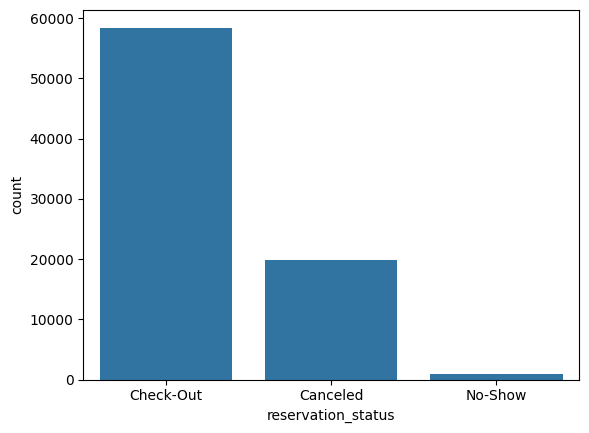

In [95]:
sns.countplot(x = 'reservation_status', data = df)
plt.show()

Grouping the number of nights and the reservation statues to plot each reservation status and it's corresponding nights as line plot. From the figure, it indicates that agents are most likely to reserve hotel rooms for 2 to 6 nights. Which increases the chance to cancel the reservation since high number of reservations happened.

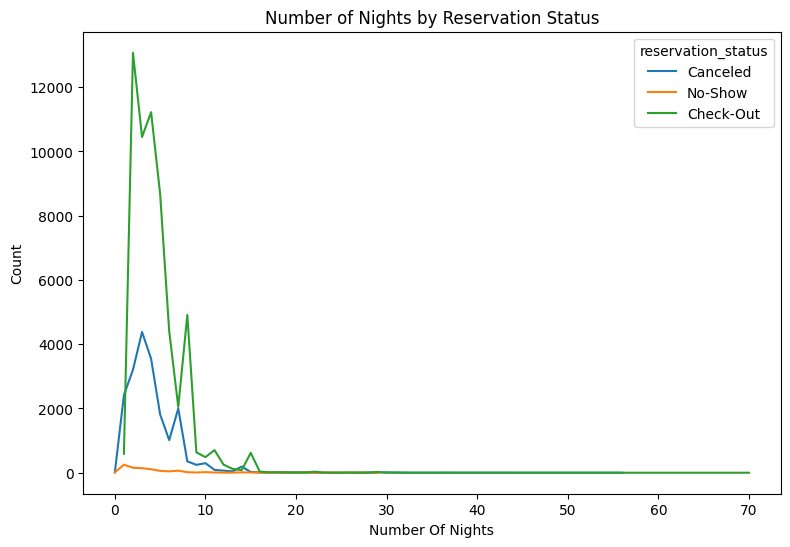

In [96]:
night_counts = df.groupby(['number_of_nights', 'reservation_status']).size().reset_index(name='count')

plt.figure(figsize=(9, 6))
sns.lineplot(x='number_of_nights', y='count', hue='reservation_status', data=night_counts)

plt.xlabel('Number Of Nights')
plt.ylabel('Count')
plt.title('Number of Nights by Reservation Status')
plt.show()

Grouping the arrival date month and reseravtion status and plotting them as a line plot to see the number of reservations for each month. It indicates thath the reservations occurrs more in in July and Augest.

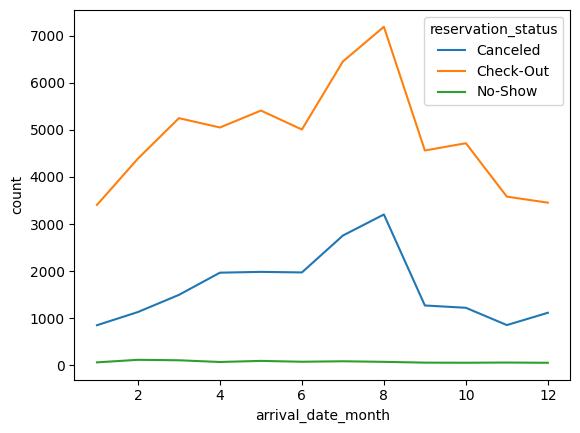

In [97]:
df['arrival_date_month'] = df['arrival_date_month'].astype(int)
df_count = df.groupby(['arrival_date_month', 'reservation_status']).size().reset_index(name='count')
sns.lineplot(x='arrival_date_month', y='count', hue='reservation_status', data=df_count)
plt.show()

Grouping the season with the reservation status. Similar to the previous plot, but indicates to in which season the most reservations are. Also, it proved that the most reservations happened in the summer.

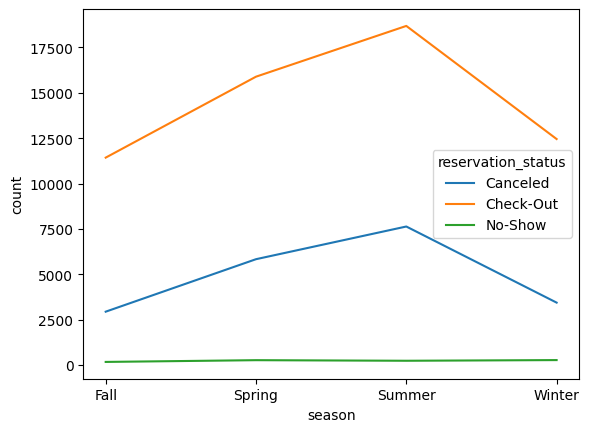

In [98]:
df_count = df.groupby(['season', 'reservation_status']).size().reset_index(name='count')
sns.lineplot(x='season', y='count', hue='reservation_status', data=df_count)
plt.show()

Grouping days of the month and the reservation status. The plot indicates that agents usually does not prefer to reserve in the last days of a month which shows that the least checking out is at the end of the months.

<Axes: xlabel='arrival_date_day_of_month', ylabel='count'>

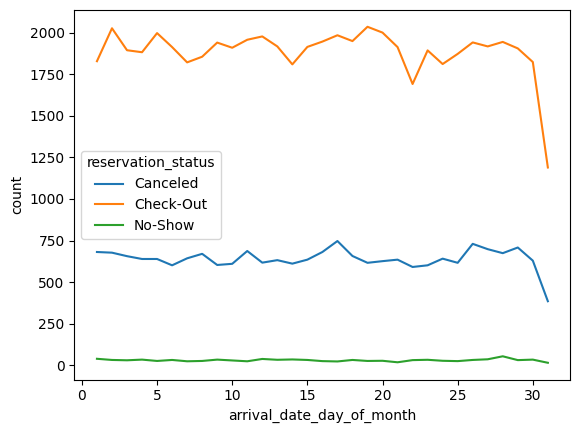

In [99]:
df_count = df.groupby(['arrival_date_day_of_month', 'reservation_status']).size().reset_index(name='count')
sns.lineplot(x='arrival_date_day_of_month', y='count', hue='reservation_status', data=df_count)

Creating a contingency table then use it as a confusion matrix to compare between the reserved room type and the assigned room type. It indicates that most of agents got assigned to their reserved room. However, there is 15.38% assigning mistakes where agent reserved for a type and got assigned to another type. Then we did calculations to detect how much of that percantage (15.38%) is cancelled reservations. It shows that 3.06% out of the 15.38% mistakes were cancelled reservations but the rest are not. Which indicates that the room type is not a factor on affecting the reservation status.

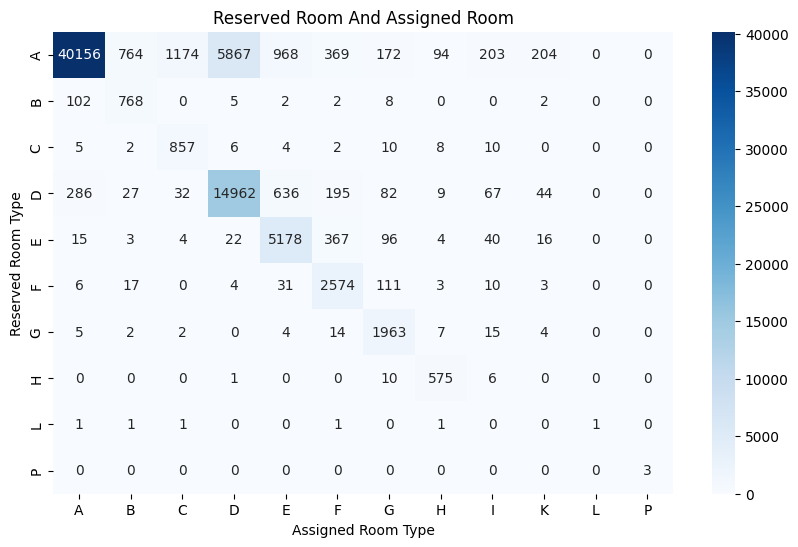


Missmatch Percentage Between Reserved And Assigned Room Types: 15.38%




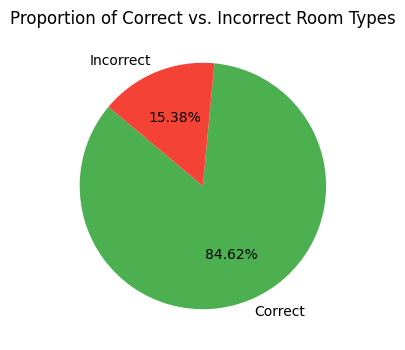


Cancellation Percentage for Incorrect Room Types: 3.06% Out Of The 15.38%


In [100]:
import pandas as pd
roomtype = pd.crosstab(df['reserved_room_type'], df['assigned_room_type'])
plt.figure(figsize=(10, 6))
sns.heatmap(roomtype, annot=True, cmap='Blues', fmt='d')
plt.title('Reserved Room And Assigned Room')
plt.xlabel('Assigned Room Type')
plt.ylabel('Reserved Room Type')
plt.show()


df['wrong_room_type'] = df['reserved_room_type'] != df['assigned_room_type']
wrong_num = df['wrong_room_type'].sum()
total_reservations = df.shape[0]
faults = (wrong_num / total_reservations) * 100
print(f"\nMissmatch Percentage Between Reserved And Assigned Room Types: {faults:.2f}%")
print("\n")

labels = ['Correct', 'Incorrect']
sizes = [total_reservations - wrong_num, wrong_num]
colors = ['#4CAF50', '#F44336']
plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=140)
plt.title('Proportion of Correct vs. Incorrect Room Types')
plt.show()

df_wrong_room = df[df['wrong_room_type']]
canceled_wrong_room = df_wrong_room[df_wrong_room['reservation_status'] == 'Canceled'].shape[0]
total_wrong_room = df_wrong_room.shape[0]
cancellation_percentage_wrong_room = (canceled_wrong_room / total_wrong_room) * 100
print(f"\nCancellation Percentage for Incorrect Room Types: {cancellation_percentage_wrong_room:.2f}% Out Of The {faults:.2f}%")


df = df.drop(['wrong_room_type'], axis = 1)

Plotting meal plans according to the reservation status. It indicates that there is no clear relation about meals plan to influnce the reservation status.

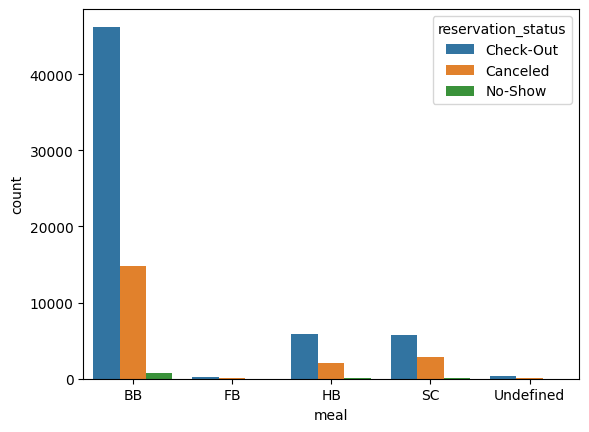

In [101]:
sns.countplot(x = 'meal', hue = 'reservation_status', data =df)
plt.show()

We created a dataframe that only contains 1 or more car parking spaces. Then plotting pie plot that shows how the reservation status is when the condition is applied. According to the data, it indicates that when an agent request 1 or more car parks spaces, the reservation would be checking out 100%. Which indicates that car parking spaces requests are a huge influencer on the reservation status.

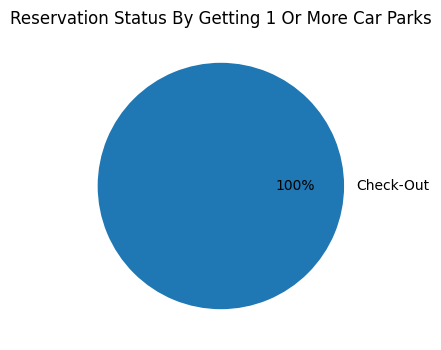

In [102]:
checkpark = df[df['required_car_parking_spaces'] >= 1]
carparkscount = checkpark.groupby('reservation_status')['required_car_parking_spaces'].count()

plt.figure(figsize=(4, 4))
plt.pie(carparkscount, labels=carparkscount.index, autopct='%1.0f%%', startangle=180)
plt.title('Reservation Status By Getting 1 Or More Car Parks')
plt.show()

plotting the reservation status when agents ask certain amount of special requests. First, when 0 requests occured, there is a chance of 30% that the reservation would be cancelled. However, when more requests were asked, the percentage of cancellation decreased. 1 special request decreased the cancellation status to 21%. 2 special requests decreased the cancellation status to 20%. 3 special requests decreased the cancellation status to 16%. 4 special requests decreased the cnacellation status to 10%. Lastly, 5 special requests decreased the cancellation status to 6%. It indicates that the more the special requests are, the less chance to the reservation to get cancelled.

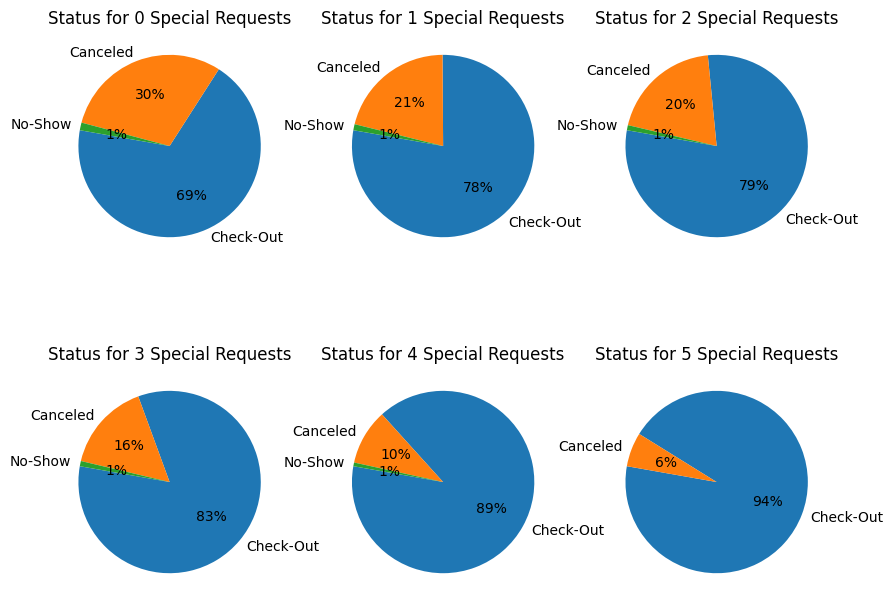

In [103]:
checkpark = df[df['total_of_special_requests'] >= 0]

checkpark['special_requests_bin'] = checkpark['total_of_special_requests']
bins = sorted(checkpark['special_requests_bin'].unique())

plt.figure(figsize=(10, 8))

for i, bin_value in enumerate(bins):
    plt.subplot(2, 3, i+1)
    bin_data = checkpark[checkpark['special_requests_bin'] == bin_value]
    status_counts = bin_data['reservation_status'].value_counts()

    plt.pie(status_counts, labels=status_counts.index, autopct='%1.0f%%', startangle=170)
    plt.title(f'Status for {bin_value} Special Requests')

plt.show()

Plotting deposit type according to the reservation status. It indicates that almost all reservations were No deposit type which cannot conclude a relation from it.

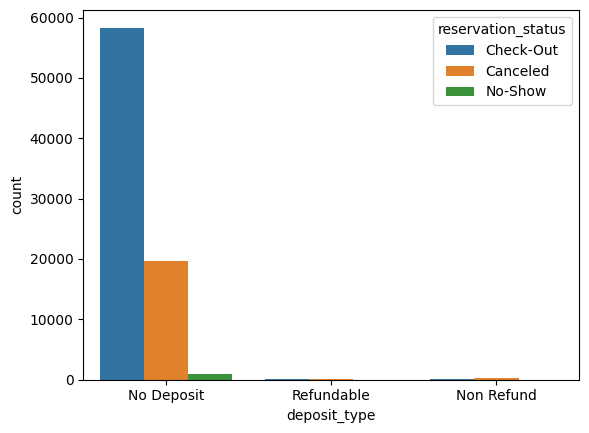

In [104]:
sns.countplot(x = 'deposit_type' , hue = 'reservation_status', data = df)
plt.show()

Plotting the most five cancellation reservations happened in countries. It indicates that Portugal is significantly highest cancellation status, then United Kingdom, Spain, France and Italy share almost the same cancellation observations. However, the most five reservations that occurd successfully was also in Portugal singnificantly compared to other countries. Which indicates that the null values of the country feature could not be filled randomlly or filled on these countries to prevent biases from happening.

<ipython-input-105-a1b8164e29b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agentsumm['reservation_status'] = agentsumm['reservation_status'].replace('Check-Out' , 1)
<ipython-input-105-a1b8164e29b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agentsumm['reservation_status'] = agentsumm['reservation_status'].replace('Canceled' , 0)
<ipython-input-105-a1b8164e29b3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

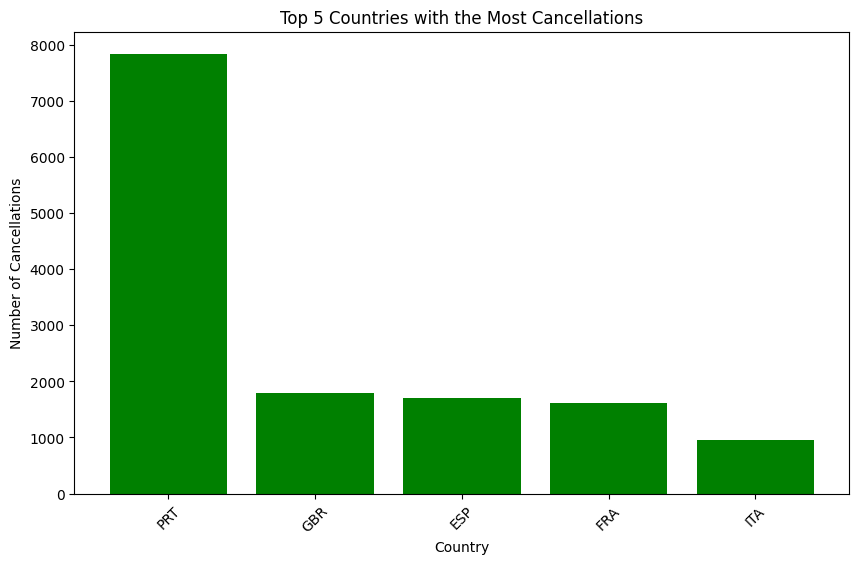

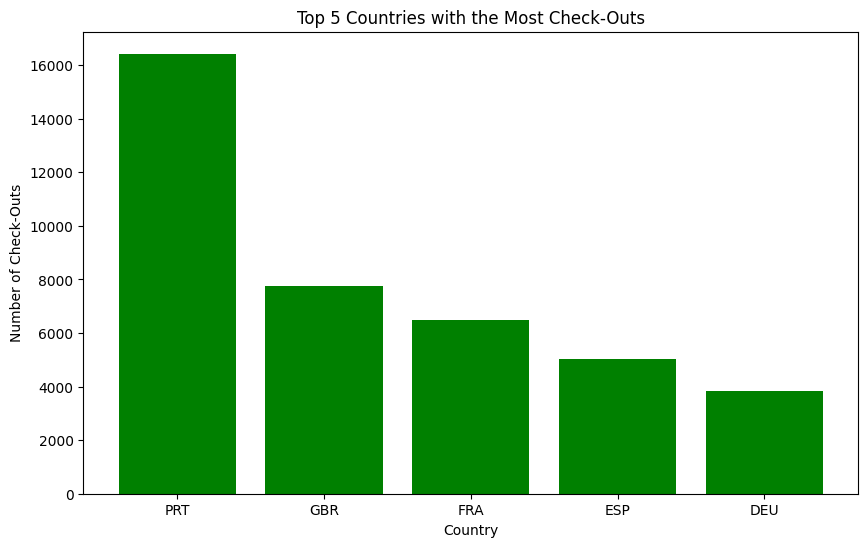

In [105]:
agentsumm = df[['agent', 'country' , 'reservation_status']]
agentsumm['reservation_status'] = agentsumm['reservation_status'].replace('Check-Out' , 1)
agentsumm['reservation_status'] = agentsumm['reservation_status'].replace('Canceled' , 0)
agentsumm['reservation_status'] = agentsumm['reservation_status'].replace('No-Show' , 0)
country_summary = pd.DataFrame(agentsumm.groupby('country')['reservation_status'].agg(check_outs='sum', cancellations=lambda x: (x == 0).sum()).reset_index())

top5 = country_summary.sort_values(by='cancellations', ascending=False).head(5)

plt.figure(figsize=(10, 6))
plt.bar(top5['country'], top5['cancellations'], color='green')
plt.xlabel('Country')
plt.ylabel('Number of Cancellations')
plt.title('Top 5 Countries with the Most Cancellations')
plt.xticks(rotation=45)
plt.show()

print("\n")

top5 = country_summary.sort_values(by='check_outs', ascending=False).head(5)
plt.figure(figsize=(10, 6))
plt.bar(top5['country'], top5['check_outs'], color='green')
plt.xlabel('Country')
plt.ylabel('Number of Check-Outs')
plt.title('Top 5 Countries with the Most Check-Outs')

plt.show()

In [106]:
end_time = time.time()
print("Time: " , end_time - start_time)
print("CPU: " , psutil.cpu_percent())
print("RAM: " , psutil.virtual_memory().percent)

Time:  12.230636358261108
CPU:  80.2
RAM:  28.0


### JSON

In [107]:
start_js = time.time()

#### ITALY

In [108]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode
spark = SparkSession.builder.appName("JSONParsing").getOrCreate()
pathjson = "/content/Rome.json"
json_df = spark.read.json(pathjson)

booking_df = json_df.select(explode(col("bookingHotels")).alias("hotel")) \
    .select(
        col("hotel.price.value").alias("price_value"),
        col("hotel.rating.score").alias("rating_score"),
        col("hotel.subwayAccess").alias("subway_access"),)

hotels_com_df = json_df.select(explode(col("hotelsComHotels")).alias("hotel")) \
    .select(
        col("hotel.price.value").alias("price_value"),
        col("hotel.rating.score").alias("rating_score"),
    )

booking_df.show(3,truncate=False)
hotels_com_df.show(3,truncate=False)

+-----------+------------+-------------+
|price_value|rating_score|subway_access|
+-----------+------------+-------------+
|2606       |9           |false        |
|182        |8.1         |false        |
|234        |7.5         |false        |
+-----------+------------+-------------+
only showing top 3 rows

+-----------+------------+
|price_value|rating_score|
+-----------+------------+
|724        |9.6         |
|791        |9.2         |
|210        |9.8         |
+-----------+------------+
only showing top 3 rows



In [109]:
booking_df_selected = booking_df.select(
    col("price_value"),
    col("rating_score"),
    col("subway_access")
)
df_booking = booking_df_selected.toPandas()
print(df_booking.head(3))

print("\n")
hotels_com_df_selected = hotels_com_df.select(
    col("price_value"),
    col("rating_score"),

)

df_hotel = hotels_com_df_selected.toPandas()
print(df_hotel.head(3))

merged_df = pd.merge(df_booking, df_hotel, on=['price_value', 'rating_score'], how='outer')
print(merged_df.info())
merged_df['rating_score'] = merged_df['rating_score'].replace('No rating' , 0)
merged_df['rating_score'] = merged_df['rating_score'].astype(float)
merged_df = merged_df[merged_df['rating_score'] != 0]

bins = [0, 6, 7, 8, 9, 10]
labels = ['Poor', 'Average', 'Good', 'Very Good', 'Wonderful']
merged_df['rating_description'] = pd.cut(merged_df['rating_score'], bins=bins, labels=labels, right=False)

   price_value rating_score  subway_access
0         2606            9          False
1          182          8.1          False
2          234          7.5          False


   price_value rating_score
0          724          9.6
1          791          9.2
2          210          9.8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   price_value    704 non-null    int64 
 1   rating_score   704 non-null    object
 2   subway_access  208 non-null    object
dtypes: int64(1), object(2)
memory usage: 16.6+ KB
None


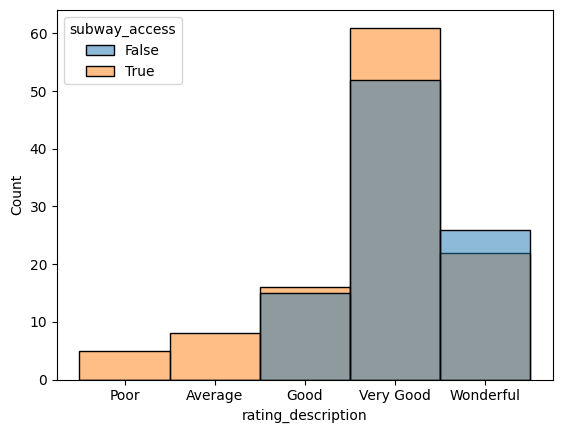

<ipython-input-110-fdae0cb856b5>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_prices = merged_df.groupby('rating_description')['price_value'].mean().reset_index()


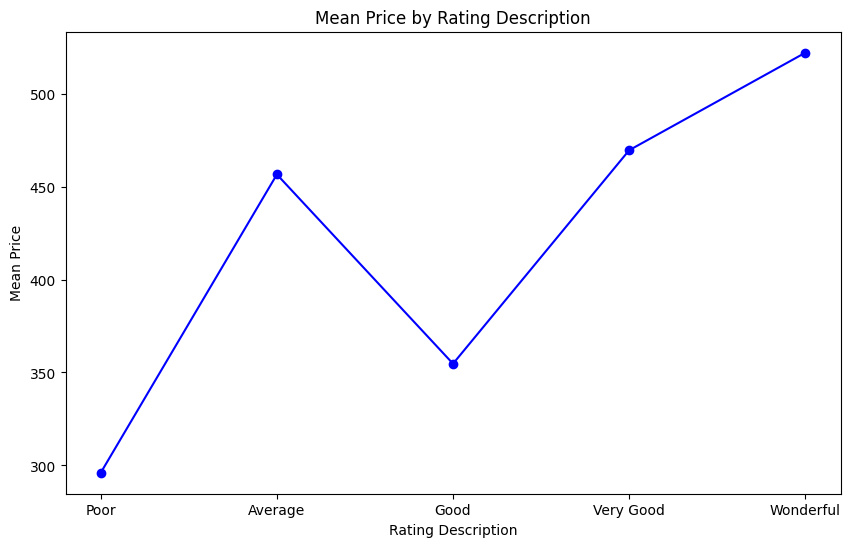

In [110]:
import seaborn as sns
sns.histplot(x = 'rating_description', hue ='subway_access',data = merged_df)
plt.show()
mean_prices = merged_df.groupby('rating_description')['price_value'].mean().reset_index()

rating_order = ['Poor', 'Average', 'Good', 'Very Good', 'Wonderful']
mean_prices['rating_description'] = pd.Categorical(mean_prices['rating_description'], categories=rating_order, ordered=True)
mean_prices = mean_prices.sort_values('rating_description')

plt.figure(figsize=(10, 6))
plt.plot(mean_prices['rating_description'], mean_prices['price_value'], marker='o', linestyle='-', color='b')
plt.xlabel('Rating Description')
plt.ylabel('Mean Price')
plt.title('Mean Price by Rating Description')
plt.show()

The mean prices in italy for good and better hotels between 370 to more than 500 which is expensive comparing to other europe capitals such as Franc and Madrid. In addition, their hotels provide no subway access which means no transportation provided by the hoter nor near the hotel. The fact as from our analysis in the CSV file of hotel reservations, we saw that parking car spaces has huge influence on the reservation status. In another meaning, transportation methods are important for guests. After further analysis, we saw that the cancellation of reservations rate in Italy is 34.63% of all Italy destinations. Which considered high comparing to other European capitals. We could assume that transportation is INDEED important for all guests. In addition to price that may have big influence on the reservation status as well because other capitals (such as Paris for example) has low average prices for good and better hotels and providing subway access (which means avaliability of transportation method.

In [111]:
df_ita = df[df['country'] == 'ITA']

reservation_totals = df_ita['reservation_status'].value_counts().reset_index()
reservation_totals.columns = ['reservation_status', 'total']
print(reservation_totals)
print("\n")

total_reservations = reservation_totals['total'].sum()
canceled_reservations = reservation_totals.loc[reservation_totals['reservation_status'] == 'Canceled', 'total'].values[0]
cancellation_rate = (canceled_reservations / total_reservations) * 100
print(f"Cancellation Rate: {cancellation_rate:.2f}%")

  reservation_status  total
0          Check-Out   1772
1           Canceled    947
2            No-Show     16


Cancellation Rate: 34.63%


#### Madrid

In [112]:
pathjson = "/content/Madrid.json"
json_df = spark.read.json(pathjson)
json_df.printSchema()

booking_df = json_df.select(explode(col("bookingHotels")).alias("hotel")) \
    .select(
        col("hotel.price.value").alias("price_value"),
        col("hotel.rating.score").alias("rating_score"),
        col("hotel.subwayAccess").alias("subway_access"),)

hotels_com_df = json_df.select(explode(col("hotelsComHotels")).alias("hotel")) \
    .select(
        col("hotel.price.value").alias("price_value"),
        col("hotel.rating.score").alias("rating_score"),)

booking_df.show(3,truncate=False)
hotels_com_df.show(3,truncate=False)

root
 |-- airbnbHotels: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- link: string (nullable = true)
 |    |    |-- price: struct (nullable = true)
 |    |    |    |-- currency: string (nullable = true)
 |    |    |    |-- period: string (nullable = true)
 |    |    |    |-- value: long (nullable = true)
 |    |    |-- rating: string (nullable = true)
 |    |    |-- subtitles: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- thumbnail: string (nullable = true)
 |    |    |-- title: string (nullable = true)
 |-- bookingHotels: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- distanceFromCenter: double (nullable = true)
 |    |    |-- highlights: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- link: string (nullable = true)
 |    |    |-- location: string (nullable = true)
 |    |    |-- preferredBadge: boolean (nu

In [113]:
booking_df_selected = booking_df.select(
    col("price_value"),
    col("rating_score"),
    col("subway_access")
)
df_booking = booking_df_selected.toPandas()
print(df_booking.head(3))

print("\n")
hotels_com_df_selected = hotels_com_df.select(
    col("price_value"),
    col("rating_score"),

)

df_hotel = hotels_com_df_selected.toPandas()
print(df_hotel.head(3))

merged_df = pd.merge(df_booking, df_hotel, on=['price_value', 'rating_score'], how='outer')
print(merged_df.info())
merged_df['rating_score'] = merged_df['rating_score'].replace('No rating' , 0)
merged_df['rating_score'] = merged_df['rating_score'].astype(float)
merged_df = merged_df[merged_df['rating_score'] != 0]

bins = [0, 6, 7, 8, 9, 10]
labels = ['Poor', 'Average', 'Good', 'Very Good', 'Wonderful']
merged_df['rating_description'] = pd.cut(merged_df['rating_score'], bins=bins, labels=labels, right=False)

   price_value rating_score  subway_access
0          233          8.9           True
1           77          8.1          False
2           82          7.9           True


   price_value rating_score
0          169          9.2
1          166          8.4
2          100          9.2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   price_value    958 non-null    int64 
 1   rating_score   958 non-null    object
 2   subway_access  508 non-null    object
dtypes: int64(1), object(2)
memory usage: 22.6+ KB
None


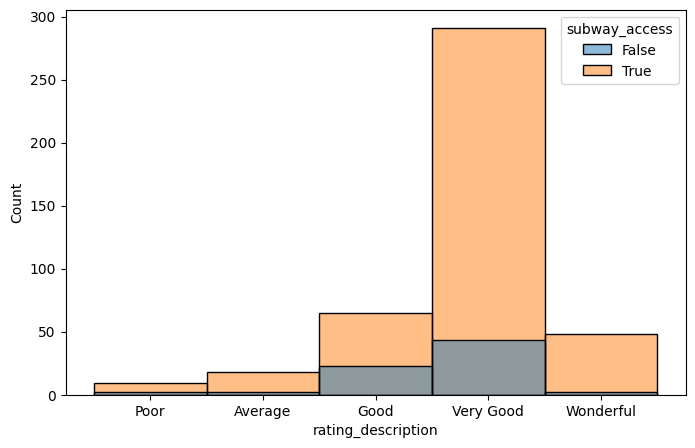

<ipython-input-114-685573ee81da>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_prices = merged_df.groupby('rating_description')['price_value'].mean().reset_index()


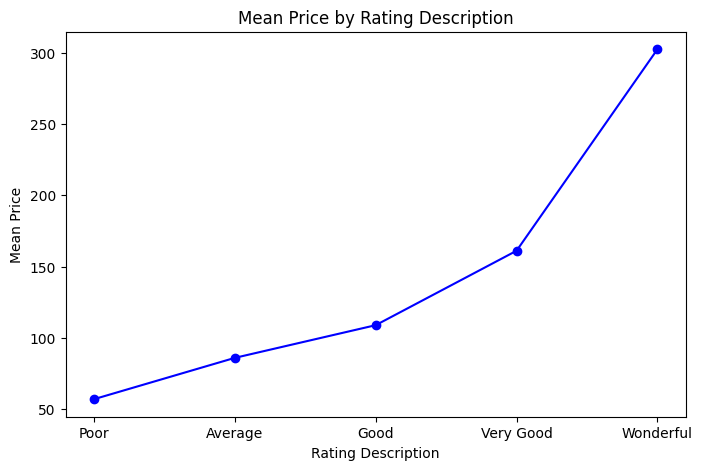

In [114]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.histplot(x = 'rating_description', hue ='subway_access',data = merged_df)
plt.show()


mean_prices = merged_df.groupby('rating_description')['price_value'].mean().reset_index()
rating_order = ['Poor', 'Average', 'Good', 'Very Good', 'Wonderful']
mean_prices['rating_description'] = pd.Categorical(mean_prices['rating_description'], categories=rating_order, ordered=True)
mean_prices = mean_prices.sort_values('rating_description')

plt.figure(figsize=(8, 5))
plt.plot(mean_prices['rating_description'], mean_prices['price_value'], marker='o', linestyle='-', color='b')
plt.xlabel('Rating Description')
plt.ylabel('Mean Price')
plt.title('Mean Price by Rating Description')
plt.show()

In the CSV dataset, we saw requesting parking cars has huge influencing on the reservation status. We can assume that transportation methods is important for guests where it shows that hotels would get High Score for having transportations methods whether served by the hotel or nearby. In addition, the mean prices in Spain is averagly low compared to Italy. Which also could be an assumption for why Spain has less cancellation status as shown down in the table.

In [115]:
df_ita = df[df['country'] == 'ESP']

reservation_totals = df_ita['reservation_status'].value_counts().reset_index()
reservation_totals.columns = ['reservation_status', 'total']
print(reservation_totals)
print("\n")

total_reservations = reservation_totals['total'].sum()
canceled_reservations = reservation_totals.loc[reservation_totals['reservation_status'] == 'Canceled', 'total'].values[0]
cancellation_rate = (canceled_reservations / total_reservations) * 100
print(f"Cancellation Rate: {cancellation_rate:.2f}%")

  reservation_status  total
0          Check-Out   5026
1           Canceled   1669
2            No-Show     30


Cancellation Rate: 24.82%


#### Paris

In [116]:
import pandas as pd
import json

file_path = "/content/Paris.json"
with open(file_path, 'r') as file:
    data = json.load(file)

book_dfp = pd.json_normalize(data['bookingHotels'])
hotel_dfp = pd.json_normalize(data['hotelsComHotels'])

book_dfp = book_dfp[['price.value', 'rating.score', 'subwayAccess']]
hotel_dfp = hotel_dfp[['rating.score', 'price.value']]

print("Bookings:")
print(book_dfp.head(3))
print("\n")
print("\nHotels:")
print(hotel_dfp.head(3))

Bookings:
   price.value rating.score  subwayAccess
0          625          9.2          True
1          164          8.1          True
2           76    No rating          True



Hotels:
  rating.score  price.value
0          9.2          587
1            8          229
2          8.4          251


In [117]:
merged_df = pd.merge(book_dfp, hotel_dfp, on=['price.value', 'rating.score'], how='outer')
merged_df['rating.score'] = merged_df['rating.score'].replace('No rating' , 0)
merged_df['rating.score'] = merged_df['rating.score'].astype(float)
merged_df = merged_df[merged_df['rating.score'] != 0]


bins = [0, 6, 7, 8, 9, 10]
labels = ['Poor', 'Average', 'Good', 'Very Good', 'Wonderful']
merged_df['rating_description'] = pd.cut(merged_df['rating.score'], bins=bins, labels=labels, right=False)

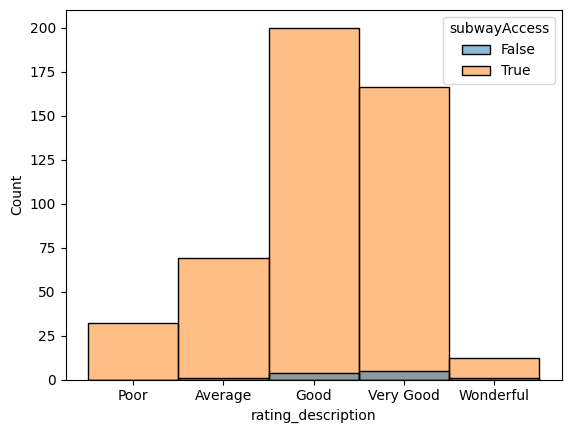

<ipython-input-118-8379bcebb0ca>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_prices = merged_df.groupby('rating_description')['price.value'].mean().reset_index()


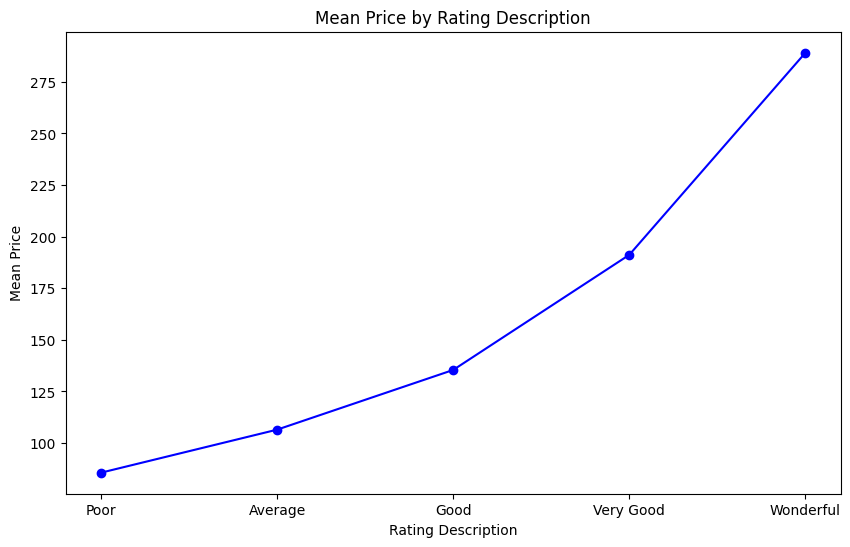

In [118]:
import seaborn as sns
sns.histplot(x = 'rating_description', hue ='subwayAccess',data = merged_df)
plt.show()
mean_prices = merged_df.groupby('rating_description')['price.value'].mean().reset_index()

rating_order = ['Poor', 'Average', 'Good', 'Very Good', 'Wonderful']
mean_prices['rating_description'] = pd.Categorical(mean_prices['rating_description'], categories=rating_order, ordered=True)
mean_prices = mean_prices.sort_values('rating_description')

plt.figure(figsize=(10, 6))
plt.plot(mean_prices['rating_description'], mean_prices['price.value'], marker='o', linestyle='-', color='b')
plt.xlabel('Rating Description')
plt.ylabel('Mean Price')
plt.title('Mean Price by Rating Description')
plt.show()

EXPLAIn

In [119]:
df_ita = df[df['country'] == 'FRA']

reservation_totals = df_ita['reservation_status'].value_counts().reset_index()
reservation_totals.columns = ['reservation_status', 'total']
print(reservation_totals)

print('\n')
total_reservations = reservation_totals['total'].sum()
canceled_reservations = reservation_totals.loc[reservation_totals['reservation_status'] == 'Canceled', 'total'].values[0]

cancellation_rate = (canceled_reservations / total_reservations) * 100
print(f"Cancellation Rate: {cancellation_rate:.2f}%")

  reservation_status  total
0          Check-Out   6498
1           Canceled   1578
2            No-Show     30


Cancellation Rate: 19.47%


#### Berlin

In [120]:
import pandas as pd
import json

file_path = "/content/Berlin.json"
with open(file_path, 'r') as file:
    data = json.load(file)

book_dfp = pd.json_normalize(data['bookingHotels'])
hotel_dfp = pd.json_normalize(data['hotelsComHotels'])

book_dfp = book_dfp[['price.value', 'rating.score', 'subwayAccess']]
hotel_dfp = hotel_dfp[['rating.score', 'price.value']]

print("Bookings:")
print(book_dfp.head(3))
print("\n")
print("\nHotels:")
print(hotel_dfp.head(3))

Bookings:
   price.value rating.score  subwayAccess
0          111          8.1          True
1           68          6.8         False
2          104          8.4         False



Hotels:
  rating.score  price.value
0          8.8          107
1          8.6          163
2          8.4           93


In [121]:
merged_df = pd.merge(book_dfp, hotel_dfp, on=['price.value', 'rating.score'], how='outer')
merged_df['rating.score'] = merged_df['rating.score'].replace('No rating' , 0)
merged_df['rating.score'] = merged_df['rating.score'].astype(float)
merged_df = merged_df[merged_df['rating.score'] != 0]


bins = [0, 6, 7, 8, 9, 10]
labels = ['Poor', 'Average', 'Good', 'Very Good', 'Wonderful']
merged_df['rating_description'] = pd.cut(merged_df['rating.score'], bins=bins, labels=labels, right=False)

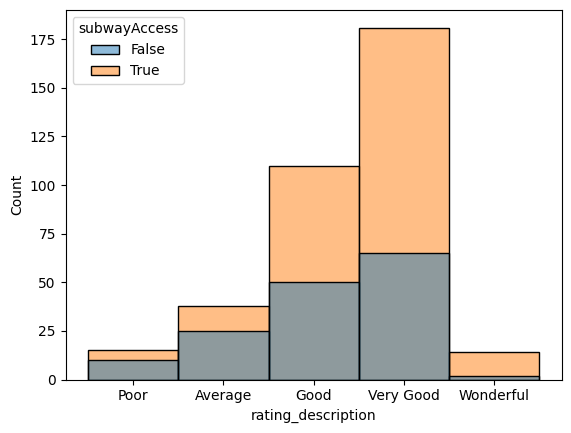

<ipython-input-122-8379bcebb0ca>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_prices = merged_df.groupby('rating_description')['price.value'].mean().reset_index()


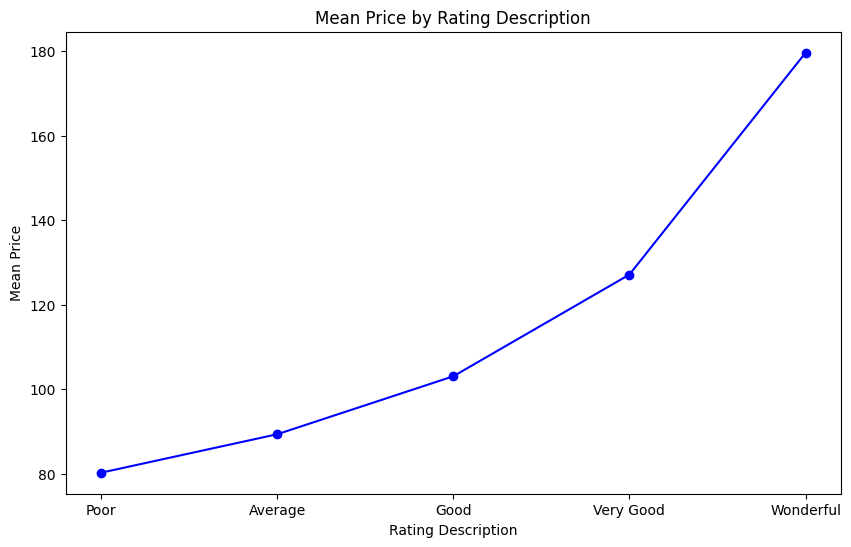

In [122]:
import seaborn as sns
sns.histplot(x = 'rating_description', hue ='subwayAccess',data = merged_df)
plt.show()
mean_prices = merged_df.groupby('rating_description')['price.value'].mean().reset_index()

rating_order = ['Poor', 'Average', 'Good', 'Very Good', 'Wonderful']
mean_prices['rating_description'] = pd.Categorical(mean_prices['rating_description'], categories=rating_order, ordered=True)
mean_prices = mean_prices.sort_values('rating_description')

plt.figure(figsize=(10, 6))
plt.plot(mean_prices['rating_description'], mean_prices['price.value'], marker='o', linestyle='-', color='b')
plt.xlabel('Rating Description')
plt.ylabel('Mean Price')
plt.title('Mean Price by Rating Description')
plt.show()

EXPLAIN

In [123]:
df_ita = df[df['country'] == 'DEU']

reservation_totals = df_ita['reservation_status'].value_counts().reset_index()
reservation_totals.columns = ['reservation_status', 'total']
print(reservation_totals)
print("\n")

total_reservations = reservation_totals['total'].sum()
canceled_reservations = reservation_totals.loc[reservation_totals['reservation_status'] == 'Canceled', 'total'].values[0]
cancellation_rate = (canceled_reservations / total_reservations) * 100
print(f"Cancellation Rate: {cancellation_rate:.2f}%")

  reservation_status  total
0          Check-Out   3836
1           Canceled    948
2            No-Show     11


Cancellation Rate: 19.77%


#### London

In [124]:
import pandas as pd
import json

file_path = "/content/London.json"
with open(file_path, 'r') as file:
    data = json.load(file)

book_dfp = pd.json_normalize(data['bookingHotels'])
hotel_dfp = pd.json_normalize(data['hotelsComHotels'])

book_dfp = book_dfp[['price.value', 'rating.score', 'subwayAccess']]
hotel_dfp = hotel_dfp[['rating.score', 'price.value']]

print("Bookings:")
print(book_dfp.head(3))
print("\n")
print("\nHotels:")
print(hotel_dfp.head(3))

Bookings:
   price.value rating.score  subwayAccess
0          247          8.4          True
1          212          8.8         False
2          259          8.5          True



Hotels:
  rating.score  price.value
0          8.6          178
1          8.4          312
2          8.2          168


In [125]:
merged_df = pd.merge(book_dfp, hotel_dfp, on=['price.value', 'rating.score'], how='outer')
merged_df['rating.score'] = merged_df['rating.score'].replace('No rating' , 0)
merged_df['rating.score'] = merged_df['rating.score'].astype(float)
merged_df = merged_df[merged_df['rating.score'] != 0]


bins = [0, 6, 7, 8, 9, 10]
labels = ['Poor', 'Average', 'Good', 'Very Good', 'Wonderful']
merged_df['rating_description'] = pd.cut(merged_df['rating.score'], bins=bins, labels=labels, right=False)

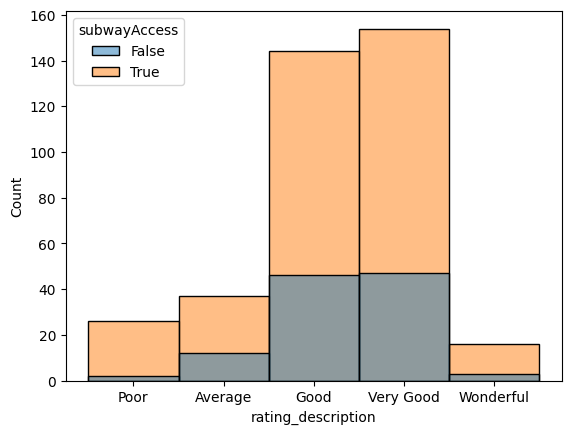

<ipython-input-126-8379bcebb0ca>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_prices = merged_df.groupby('rating_description')['price.value'].mean().reset_index()


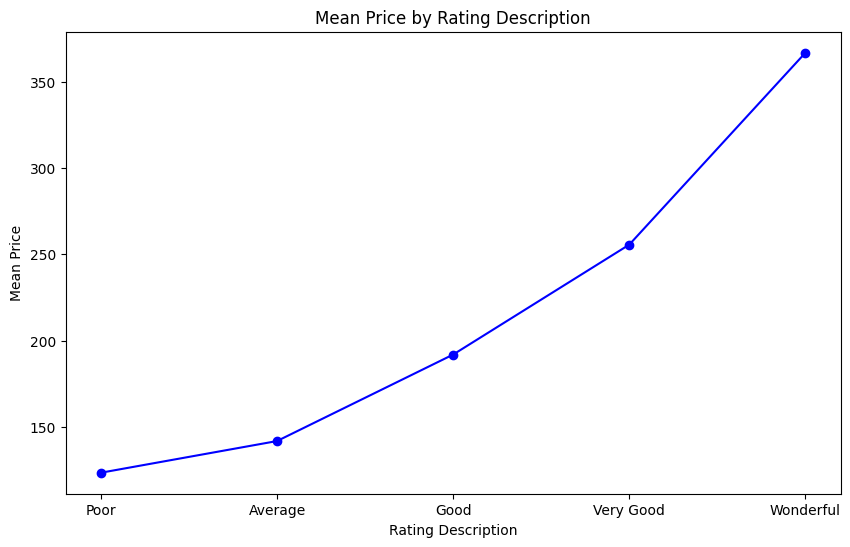

In [126]:
import seaborn as sns
sns.histplot(x = 'rating_description', hue ='subwayAccess',data = merged_df)
plt.show()
mean_prices = merged_df.groupby('rating_description')['price.value'].mean().reset_index()

rating_order = ['Poor', 'Average', 'Good', 'Very Good', 'Wonderful']
mean_prices['rating_description'] = pd.Categorical(mean_prices['rating_description'], categories=rating_order, ordered=True)
mean_prices = mean_prices.sort_values('rating_description')

plt.figure(figsize=(10, 6))
plt.plot(mean_prices['rating_description'], mean_prices['price.value'], marker='o', linestyle='-', color='b')
plt.xlabel('Rating Description')
plt.ylabel('Mean Price')
plt.title('Mean Price by Rating Description')
plt.show()

EXPLAIN

In [127]:
df_ita = df[df['country'] == 'GBR']

reservation_totals = df_ita['reservation_status'].value_counts().reset_index()
reservation_totals.columns = ['reservation_status', 'total']
print(reservation_totals)
print("\n")

total_reservations = reservation_totals['total'].sum()
canceled_reservations = reservation_totals.loc[reservation_totals['reservation_status'] == 'Canceled', 'total'].values[0]
cancellation_rate = (canceled_reservations / total_reservations) * 100
print(f"Cancellation Rate: {cancellation_rate:.2f}%")

  reservation_status  total
0          Check-Out   7770
1           Canceled   1749
2            No-Show     38


Cancellation Rate: 18.30%


#### END Resources For JSON

In [128]:
end_js = time.time()
print("Time: " , end_js - start_js)
print("CPU: " , psutil.cpu_percent())
print("RAM: " , psutil.virtual_memory().percent)

Time:  6.6035192012786865
CPU:  93.0
RAM:  27.9


### Preprocessing

In [129]:
start_time = time.time()

####Processing NAN Values For Country

Creating a new dataframe that contains the instances that has null value in the country feature. And Creating a new feature that holds the number of countries that the agent has served.

In [130]:
from pyspark.sql.functions import col, countDistinct, isnan
df = spark.createDataFrame(df)
hi2 = df.filter(isnan('country'))

contryagentfill = hi2.groupBy('agent').agg(countDistinct('country').alias('unique_countries'))
total_countries_served = df.groupBy('agent').agg(countDistinct('country').alias('countries_served_number'))

contryagentfill = contryagentfill.join(total_countries_served, on='agent', how='left')
contryagentfill.show()

+-----+----------------+-----------------------+
|agent|unique_countries|countries_served_number|
+-----+----------------+-----------------------+
|   15|               1|                     26|
|  154|               1|                      3|
|  468|               1|                      9|
|  446|               1|                      1|
|  139|               1|                      2|
|  146|               1|                      4|
|  250|               1|                     53|
|  184|               1|                      8|
|  171|               1|                     27|
|  327|               1|                      7|
|    5|               1|                     16|
|   78|               1|                      2|
|    6|               1|                     33|
|  385|               1|                      2|
|  201|               1|                      4|
|  177|               1|                     21|
|  241|               1|                     57|
|  242|             

We decided to fill the Null values of the country feature by using the mode of the agent of the corresponding instance that has the country null value. Which means that each agent has a specific mode of what countries he has served the most. So, each null value in the country feature will be filled with the mode of that specific agent.

In [131]:
from pyspark.sql.functions import col, count, when, first, row_number
from pyspark.sql.window import Window

mode_df = df.groupBy('agent', 'country').agg(count('*').alias('frequency'))

windowSpec = Window.partitionBy('agent').orderBy(col('frequency').desc())
mode_df = mode_df.withColumn('rank', row_number().over(windowSpec)).filter(col('rank') == 1).drop('frequency', 'rank')

df = df.join(mode_df.select('agent', 'country').withColumnRenamed('country', 'mode_country'),
             on='agent', how='left')

df = df.withColumn('country', when(col('country').isNull(), col('mode_country')).otherwise(col('country')))

df = df.drop('mode_country')

#### Processing NAN Values For Children

First we printed the instaces of the null values of the children feature. Then created a list of conditions to filter the data frame to display the features and attributes that are in common with the null instances to fill the null values based on the instances that share common features (according to the conditions). It shows that there is one instance that shares the similar features between the null instances and has 0 children. So, we decided to fill these 4 instances with 0 children based on the instance that shared the same features with them.

In [132]:
filtered_df = df.filter(isnan('children'))
filtered_df = df.filter(
    (col('arrival_date_month') == 8) &
    (col('meal') == 'BB') &
    (col('country') == 'PRT') &
    (col('deposit_type') == 'No Deposit') &
    (col('days_in_waiting_list') == 0) &
    (col('customer_type') == 'Transient-Party') &
    (col('required_car_parking_spaces') == 0) &
    (col('reservation_status') == 'Canceled') &
    (col('babies') == 0) &
    (col('is_repeated_guest') == 0) &
    (col('previous_cancellations') == 0) &
    (col('previous_bookings_not_canceled') == 0) &
    (col('reserved_room_type') == 'B') &
    (col('assigned_room_type') == 'B') &
    (col('booking_changes') == 0)
)
filtered_df.show()

+-----+----------+---------+-----------------+------------------+-------------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+--------------------+---------------+---------------------------+-------------------------+------------------+----------------+------+
|agent|     hotel|lead_time|arrival_date_year|arrival_date_month|arrival_date_day_of_month|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|days_in_waiting_list|  customer_type|required_car_parking_spaces|total_of_special_requests|reservation_status|number_of_nights|season|
+-----+----------+---------+-----------------+------------------+-------------------------+------+--------+------+----+-------

In [133]:
from pyspark.sql.functions import col, lit, when, isnan
df = df.withColumn('children', when(isnan('children'), lit(0)).otherwise(col('children')))
value_counts = df.groupBy("children").count()
value_counts.show()

+--------+-----+
|children|count|
+--------+-----+
|       3|   74|
|       0|71052|
|       1| 4559|
|      10|    1|
|       2| 3539|
+--------+-----+



#### Encoding

Encoding is a crucial part for modelling that convert categorical featuers into numerical features so that machines can handle them. First, using the replacing method, Hotel feature: 0 for resort hotel, 1 for city hotel. Meal feature, 0 for undefined, 1 for SC, 2 for BB, 3 for HB, 4 for FB. Season feature: 1 for Winter, 2 for Spring, 3 for Summer, 4 for Fall. Deposit Type feature: 0 for Non Refund, 1 for No Deposit, 2 for Refundable. Reservation status target: 0 for cancelled or no show since both indicates that the room reservation is cancelled, 1 for Check Out or succefully reserved. Then, for the many categorical values for features, We used indexer encoding that automaticlly encode the values. The features that got applied using the indexer are country, market segment, distribution channel, reserved room type, assigned room type, customer type. The label encoder will assign numbers on the categorical values alphabetaclly.

In [134]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

df = df.withColumn('hotel', when(col('hotel') == 'Resort Hotel', 0)
                             .when(col('hotel') == 'City Hotel', 1)
                             .otherwise(None))

df = df.withColumn('meal', when(col('meal') == 'Undefined', 0)
                             .when(col('meal') == 'SC', 1)
                             .when(col('meal') == 'BB', 2)
                             .when(col('meal') == 'HB', 3)
                             .when(col('meal') == 'FB', 4)
                             .otherwise(None))

df = df.withColumn('season', when(col('season') == 'Winter', 1)
                             .when(col('season') == 'Spring', 2)
                             .when(col('season') == 'Summer', 3)
                             .when(col('season') == 'Fall', 4)
                             .otherwise(None))

df = df.withColumn('deposit_type', when(col('deposit_type') == 'Non Refund', 0)
                                        .when(col('deposit_type') == 'No Deposit', 1)
                                        .when(col('deposit_type') == 'Refundable', 2)
                                        .otherwise(None))

df = df.withColumn('reservation_status', when(col('reservation_status') == 'Canceled', 0)
                                             .when(col('reservation_status') == 'Check-Out', 1)
                                             .when(col('reservation_status') == 'No-Show', 0)
                                             .otherwise(None))


indexer_country = StringIndexer(inputCol='country', outputCol='country_index')
indexer_market_segment = StringIndexer(inputCol='market_segment', outputCol='market_segment_index')
indexer_distribution_channel = StringIndexer(inputCol='distribution_channel', outputCol='distribution_channel_index')
indexer_reserved_room_type = StringIndexer(inputCol='reserved_room_type', outputCol='reserved_room_type_index')
indexer_assigned_room_type = StringIndexer(inputCol='assigned_room_type', outputCol='assigned_room_type_index')
indexer_customer_type = StringIndexer(inputCol='customer_type', outputCol='customer_type_index')

df = indexer_country.fit(df).transform(df)
df = indexer_market_segment.fit(df).transform(df)
df = indexer_distribution_channel.fit(df).transform(df)
df = indexer_reserved_room_type.fit(df).transform(df)
df = indexer_assigned_room_type.fit(df).transform(df)
df = indexer_customer_type.fit(df).transform(df)

df = df.drop('country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'customer_type')
df = df.withColumnRenamed('country_index', 'country')
df = df.withColumnRenamed('market_segment_index', 'market_segment')
df = df.withColumnRenamed('distribution_channel_index', 'distribution_channel')
df = df.withColumnRenamed('reserved_room_type_index', 'reserved_room_type')
df = df.withColumnRenamed('assigned_room_type_index', 'assigned_room_type')
df = df.withColumnRenamed('customer_type_index', 'customer_type')
df.show()

+-----+-----+---------+-----------------+------------------+-------------------------+------+--------+------+----+-----------------+----------------------+------------------------------+---------------+------------+--------------------+---------------------------+-------------------------+------------------+----------------+------+-------+--------------+--------------------+------------------+------------------+-------------+
|agent|hotel|lead_time|arrival_date_year|arrival_date_month|arrival_date_day_of_month|adults|children|babies|meal|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|booking_changes|deposit_type|days_in_waiting_list|required_car_parking_spaces|total_of_special_requests|reservation_status|number_of_nights|season|country|market_segment|distribution_channel|reserved_room_type|assigned_room_type|customer_type|
+-----+-----+---------+-----------------+------------------+-------------------------+------+--------+------+----+-----------------+--------

In [135]:
print("Unique values in 'hotel' after mapping:")
df.select('hotel').distinct().show()

print("Unique values in 'meal' after mapping:")
df.select('meal').distinct().show()

print("Unique values in 'season' after mapping:")
df.select('season').distinct().show()

print("Unique values in 'deposit_type' after mapping:")
df.select('deposit_type').distinct().show()

print("Unique values in 'reservation_status' after mapping:")
df.select('reservation_status').distinct().show()

Unique values in 'hotel' after mapping:
+-----+
|hotel|
+-----+
|    1|
|    0|
+-----+

Unique values in 'meal' after mapping:
+----+
|meal|
+----+
|   1|
|   3|
|   4|
|   2|
|   0|
+----+

Unique values in 'season' after mapping:
+------+
|season|
+------+
|     1|
|     3|
|     4|
|     2|
+------+

Unique values in 'deposit_type' after mapping:
+------------+
|deposit_type|
+------------+
|           1|
|           2|
|           0|
+------------+

Unique values in 'reservation_status' after mapping:
+------------------+
|reservation_status|
+------------------+
|                 1|
|                 0|
+------------------+



#### Preprocessing NAN Values For Agents

In [136]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

df = df.toPandas()
df = df.replace('NULL' , np.nan)

df_missing = df[df['agent'].isnull()]
df_non_missing = df.dropna(subset=['agent'])

X_non_missing = df_non_missing.drop(['agent'] , axis = 1)
y_non_missing = df_non_missing['agent']
X_missing = df_missing.drop(['agent'] , axis = 1)

model = RandomForestClassifier()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_non_missing, y_non_missing, test_size=0.2, random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred, average = 'macro')
print(f"R^2 Score: {f1}")

df = spark.createDataFrame(df)
df = df.withColumn('agent', when(isnan('agent'), lit(0)).otherwise(col('agent')))

R^2 Score: 0.43197456473841184


Seems that the classifier could not predict the exact number of the agent ID. While the regressor predicted new ID agents that does not exist.
Even though the performance is too low, it is not proper because each ID represent a company. In addition, filling any value that might be wrong is not acceptable as well because it will be illegal to fill the data behalf a company that did not COMIT the booking. So, the NAN instances will be assinged as number 0 which would indicate as "unknown" and there is no agent has that ID.

#### End Time

In [137]:
end_time = time.time()
print("Time: " , end_time - start_time)
print("CPU: " , psutil.cpu_percent())
print("RAM: " , psutil.virtual_memory().percent)

Time:  110.84297943115234
CPU:  79.5
RAM:  82.3


### Modelling

In modelling phase, we used Random Forest Classifier since it is robust against outliers and ensemble model that is enhanced to deal with classification problems. First, defining x that takes the features that will help to predict y which is the target.
X is all features excluding: the target, season and arrival date day of month because the arrival month will be enough. reserved room type becaue in the EDA it was shown that the assigned room is not an influencer on the target so we only took the assigned room type. days in waiting list and babies were shown in the feature importance unction that they were not important in the prediction phase (that was shown after multiple experiments).
deposit type since nearly all the data has one type which is no deposit.
distrubution channel because the market segment about the same as the distribution channel with slight differences, so removing it will reduce the model complexity and prevent multicolinearity.

Then, initializing the model that has the classier with 70 decision trees with a max depth of 32. These are hyperparameters that tries to enhance the model to increase or decrease it's complexity to give better performance.

Starting with splitting the data to 80% for training and 20% for testing... then fitting the model with the training set to learn patterns. Lastly start predicting the test set.

To measure the performance, we used the evaluation metrics of F1 Score, accuracy, recall and precision. The results were reasonable giving an overall performance about 85%.

Also plotting the confusion matrix which shows that the model is mistaking in the minority class of the data which is the cancellation reservation status.

In [138]:
start_time = time.time()

In [139]:
df.show()

+-----+-----+---------+-----------------+------------------+-------------------------+------+--------+------+----+-----------------+----------------------+------------------------------+---------------+------------+--------------------+---------------------------+-------------------------+------------------+----------------+------+-------+--------------+--------------------+------------------+------------------+-------------+
|agent|hotel|lead_time|arrival_date_year|arrival_date_month|arrival_date_day_of_month|adults|children|babies|meal|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|booking_changes|deposit_type|days_in_waiting_list|required_car_parking_spaces|total_of_special_requests|reservation_status|number_of_nights|season|country|market_segment|distribution_channel|reserved_room_type|assigned_room_type|customer_type|
+-----+-----+---------+-----------------+------------------+-------------------------+------+--------+------+----+-----------------+--------

AUC-ROC: 0.9340
AUC-PR: 0.9760
Accuracy: 0.8734
F1-Score: 0.8713
Precision: 0.8705
Recall: 0.8734


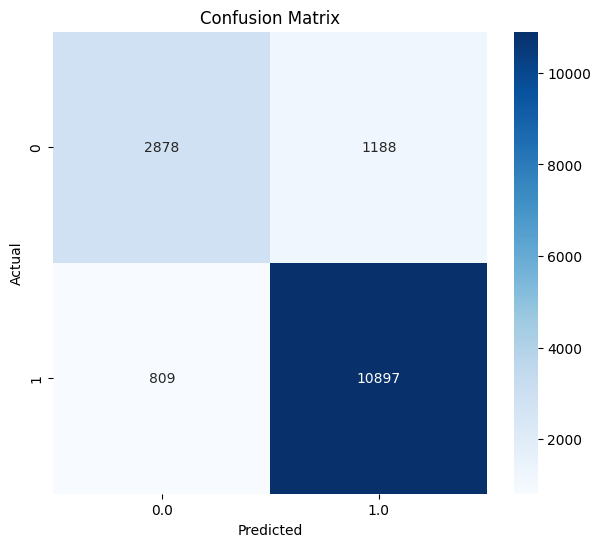

Time:  123.66387867927551
CPU:  92.8
RAM:  27.3


In [140]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml import Pipeline

for column in df.columns:
    df = df.withColumn(column, col(column).cast("integer"))

columns_to_drop = ['reservation_status', 'season', 'arrival_date_day_of_month', 'reserved_room_type',
                   'days_in_waiting_list', 'deposit_type', 'babies', 'distribution_channel']

feature_columns = [col for col in df.columns if col not in columns_to_drop]
label_column = 'reservation_status'

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

rf = RandomForestClassifier(labelCol=label_column, featuresCol="features", numTrees=35, maxDepth=20)

pipeline = Pipeline(stages=[assembler, rf])

train_df, test_df = df.randomSplit([0.8, 0.2])

model = pipeline.fit(train_df)
predictions = model.transform(test_df)

evaluator_roc = BinaryClassificationEvaluator(labelCol=label_column, metricName="areaUnderROC")
ROC = evaluator_roc.evaluate(predictions)

evaluator_pr = BinaryClassificationEvaluator(labelCol=label_column, metricName="areaUnderPR")
PR = evaluator_pr.evaluate(predictions)

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol=label_column, metricName="accuracy")
acc = evaluator_accuracy.evaluate(predictions)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol=label_column, metricName="f1")
f11 = evaluator_f1.evaluate(predictions)

evaluator_precision = MulticlassClassificationEvaluator(labelCol=label_column, metricName="weightedPrecision")
pre = evaluator_precision.evaluate(predictions)

evaluator_recall = MulticlassClassificationEvaluator(labelCol=label_column, metricName="weightedRecall")
rec = evaluator_recall.evaluate(predictions)

print(f"AUC-ROC: {ROC:.4f}")
print(f"AUC-PR: {PR:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"F1-Score: {f11:.4f}")
print(f"Precision: {pre:.4f}")
print(f"Recall: {rec:.4f}")


conma = predictions.groupBy("reservation_status", "prediction").count().toPandas()
conma.columns = ['Actual', 'Predicted', 'Count']
conmatable = conma.pivot_table(index='Actual', columns='Predicted', values='Count', fill_value=0)
conmatable = conmatable.astype(int)

plt.figure(figsize=(7, 6))
sns.heatmap(conmatable, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

end_time = time.time()
print("Time: " , end_time - start_time)
print("CPU: " , psutil.cpu_percent())
print("RAM: " , psutil.virtual_memory().percent)

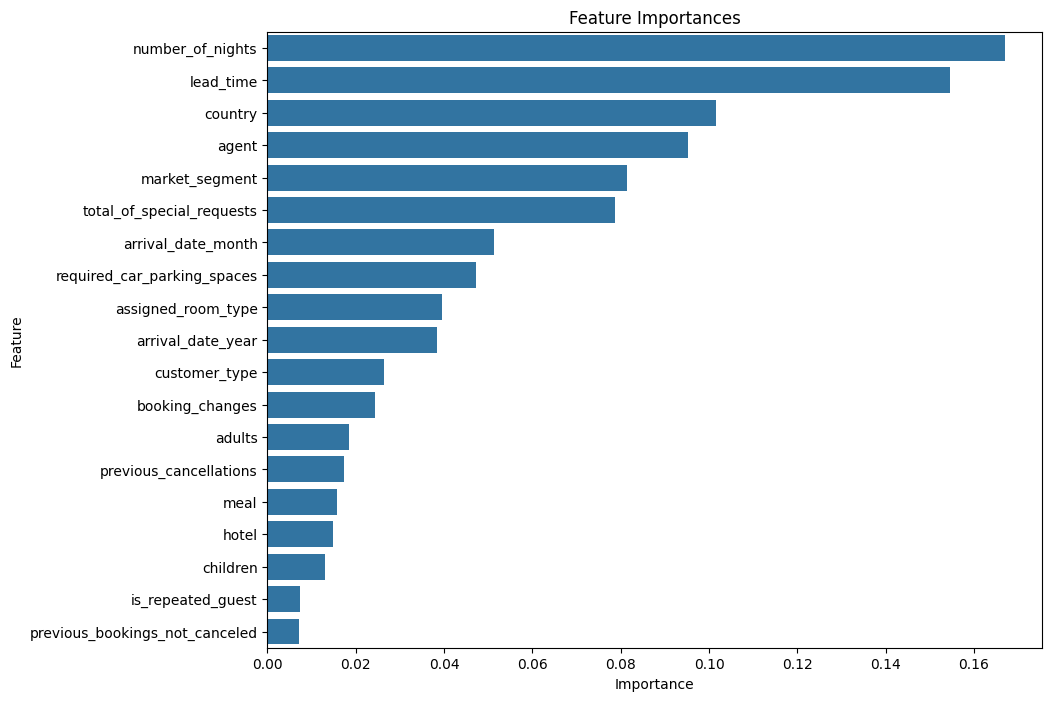

In [141]:
rf_model = model.stages[-1]
importances = rf_model.featureImportances

importances = rf_model.featureImportances.toArray()

onlyimportant = pd.DataFrame({'Feature': feature_columns,'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=onlyimportant)
plt.title('Feature Importances')
plt.show()

In [142]:
lastly_time = time.time()
print("Time: " , lastly_time - total_time)

Time:  339.308629989624
